# TP CLASSIFICATION - Chiens vs Chats

In [1]:
# Imports nécessaires
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import img_to_array
import matplotlib.image as mpimg
from skimage import transform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold  # Ajout pour la validation croisée
import seaborn as sns

## Chargement et exploration du dataset

In [2]:
# Chargement du dataset depuis le répertoire
base_dir = './PetImagesGray/'
img_width, img_height = 200, 200
Batch_Size = 64

train_datagen = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='training',
    seed=1,
    validation_split=0.15,
    batch_size=Batch_Size,
    color_mode='grayscale'
)

test_datagen = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='validation',
    seed=1,
    validation_split=0.15,
    batch_size=Batch_Size,
    color_mode='grayscale'
)

class_names = train_datagen.class_names
print(f"Classes détectées: {class_names}")

Found 800 files belonging to 2 classes.
Using 680 files for training.
Using 680 files for training.
Found 800 files belonging to 2 classes.
Using 120 files for validation.
Classes détectées: ['Cat', 'Dog']
Found 800 files belonging to 2 classes.
Using 120 files for validation.
Classes détectées: ['Cat', 'Dog']


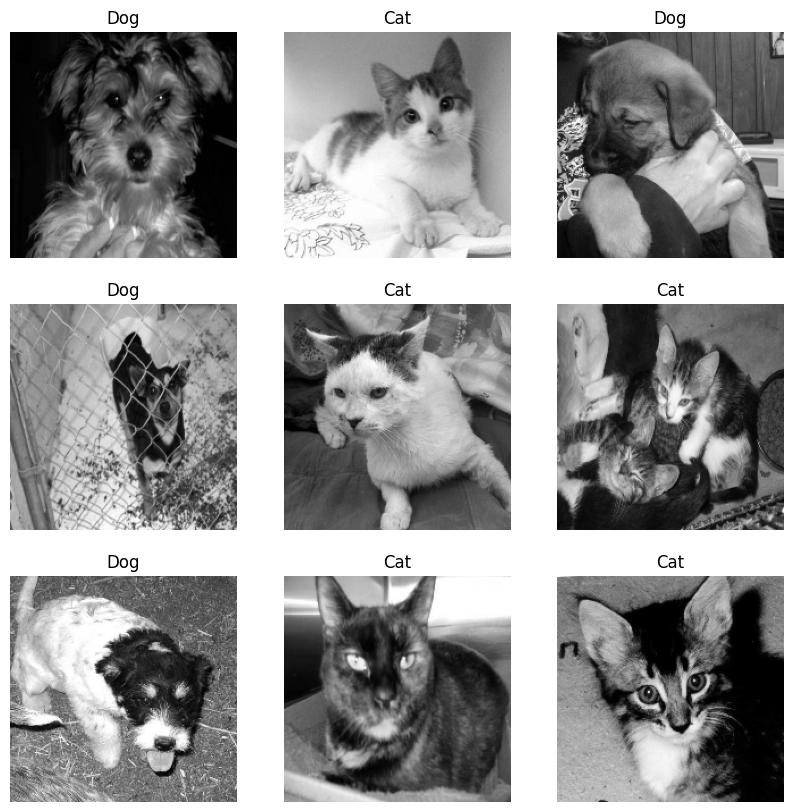

In [3]:
# Affichage de quelques exemples d'images du dataset
plt.figure(figsize=(10, 10))
for images, labels in train_datagen.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
# Normalisation des données
normalization_layer = layers.Rescaling(1./255)
train_datagen = train_datagen.map(lambda x, y: (normalization_layer(x), y))
test_datagen = test_datagen.map(lambda x, y: (normalization_layer(x), y))

## Question 1 : Modèle minimaliste avec couche de sortie

In [5]:
# Modèle minimaliste : 1 couche Conv2D (16 filtres 3x3) + 1 couche Dense (32 neurones) + couche de sortie
model_q1 = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    
    # Couche de sortie : 2 neurones (Cat/Dog) avec activation softmax
    layers.Dense(len(class_names), activation='softmax')
])

model_q1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_q1.summary()

c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,018,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,018,370 (19.14 MB)

 Trainable params: 5,018,370 (19.14 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entraînement du modèle Q1
Nb_epochs = 10
history_q1 = model_q1.fit(
    train_datagen, 
    epochs=Nb_epochs,
    validation_data=test_datagen
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.4838 - loss: 4.3918 - val_accuracy: 0.5167 - val_loss: 0.6930
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.4838 - loss: 4.3918 - val_accuracy: 0.5167 - val_loss: 0.6930
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5167 - loss: 0.6930
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5167 - loss: 0.6930

Modèle Q1 - Test Loss: 0.6930
Modèle Q1 - Test Accuracy: 0.5167

Modèle Q1 - Test Loss: 0.6930
Modèle Q1 - Test Accuracy: 0.5167


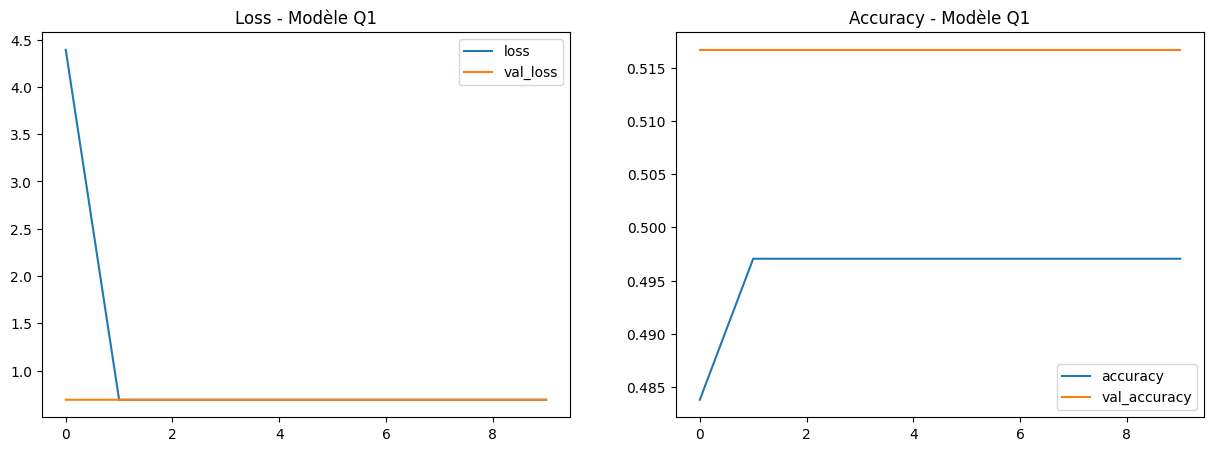

In [7]:
# Évaluation du modèle Q1
test_loss_q1, test_accuracy_q1 = model_q1.evaluate(test_datagen)
print(f'\nModèle Q1 - Test Loss: {test_loss_q1:.4f}')
print(f'Modèle Q1 - Test Accuracy: {test_accuracy_q1:.4f}')

# Visualisation des courbes
history_df_q1 = pd.DataFrame(history_q1.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
history_df_q1.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Loss - Modèle Q1')
history_df_q1.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Accuracy - Modèle Q1')
plt.show()

### Matrice de confusion - Modèle Q1

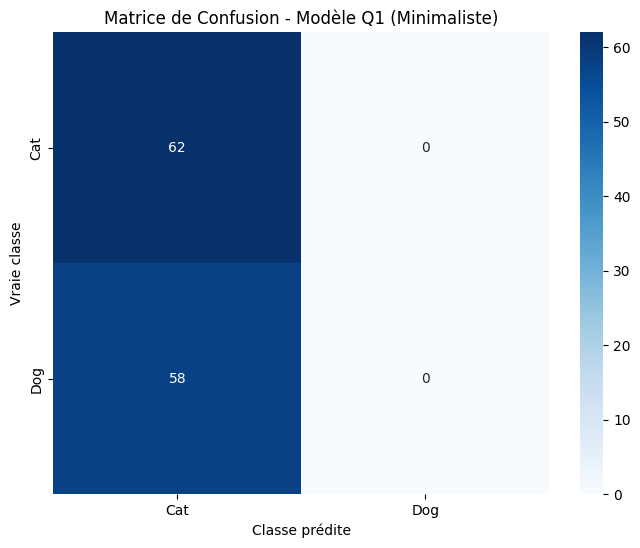


=== RAPPORT DE CLASSIFICATION Q1 ===
              precision    recall  f1-score   support

         Cat       0.52      1.00      0.68        62
         Dog       0.00      0.00      0.00        58

    accuracy                           0.52       120
   macro avg       0.26      0.50      0.34       120
weighted avg       0.27      0.52      0.35       120



c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [8]:
# Matrice de confusion pour Q1
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true_q1 = []
y_pred_q1 = []

for images, labels in test_datagen:
    predictions = model_q1.predict(images, verbose=0)
    y_true_q1.extend(labels.numpy())
    y_pred_q1.extend(np.argmax(predictions, axis=1))

cm_q1 = confusion_matrix(y_true_q1, y_pred_q1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_q1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Q1 (Minimaliste)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

print("\n=== RAPPORT DE CLASSIFICATION Q1 ===")
print(classification_report(y_true_q1, y_pred_q1, target_names=class_names))

## Question 2 : Test de variations des hyperparamètres

In [9]:
# Test avec différentes configurations
# Configuration 1 : Batch size = 32, 32 filtres, taille 5x5, 64 neurones

model_q2_config1 = tf.keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_q2_config1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== Configuration 1 : Batch=32, 32 filtres 5x5, 64 neurones ===")
model_q2_config1.summary()

=== Configuration 1 : Batch=32, 32 filtres 5x5, 64 neurones ===


c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 307328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    19,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,670,018 (75.04 MB)

 Trainable params: 19,670,018 (75.04 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Création du dataset avec batch_size=32
train_datagen_32 = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='training',
    seed=1,
    validation_split=0.1,
    batch_size=32,
    color_mode='grayscale'
).map(lambda x, y: (normalization_layer(x), y))

test_datagen_32 = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='validation',
    seed=1,
    validation_split=0.1,
    batch_size=32,
    color_mode='grayscale'
).map(lambda x, y: (normalization_layer(x), y))

# Entraînement
history_q2_config1 = model_q2_config1.fit(
    train_datagen_32,
    epochs=Nb_epochs,
    validation_data=test_datagen_32
)

test_loss_q2_c1, test_accuracy_q2_c1 = model_q2_config1.evaluate(test_datagen_32)
print(f'\nConfig 1 - Test Accuracy: {test_accuracy_q2_c1:.4f}')

Found 800 files belonging to 2 classes.
Using 720 files for training.
Using 720 files for training.
Found 800 files belonging to 2 classes.
Using 80 files for validation.
Found 800 files belonging to 2 classes.
Using 80 files for validation.
Epoch 1/10
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5000 - loss: 3.7217 - val_accuracy: 0.4750 - val_loss: 0.6839
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5000 - loss: 3.7217 - val_accuracy: 0.4750 - val_loss: 0.6839
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.6667 - loss: 0.6502 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.6667 - loss: 0.6502 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.7903 - loss: 0.4974 - val_accuracy: 0.6500 - val_loss: 0.6446
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.7903 - loss: 0.4974 - val_accuracy: 0.650

In [11]:
# Configuration 2 : Batch size = 128, 64 filtres, taille 3x3, 128 neurones

model_q2_config2 = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_q2_config2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== Configuration 2 : Batch=128, 64 filtres 3x3, 128 neurones ===")

# Dataset avec batch_size=128
train_datagen_128 = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='training',
    seed=1,
    validation_split=0.1,
    batch_size=128,
    color_mode='grayscale'
).map(lambda x, y: (normalization_layer(x), y))

test_datagen_128 = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='validation',
    seed=1,
    validation_split=0.1,
    batch_size=128,
    color_mode='grayscale'
).map(lambda x, y: (normalization_layer(x), y))

history_q2_config2 = model_q2_config2.fit(
    train_datagen_128,
    epochs=Nb_epochs,
    validation_data=test_datagen_128
)

test_loss_q2_c2, test_accuracy_q2_c2 = model_q2_config2.evaluate(test_datagen_128)
print(f'\nConfig 2 - Test Accuracy: {test_accuracy_q2_c2:.4f}')

=== Configuration 2 : Batch=128, 64 filtres 3x3, 128 neurones ===
Found 800 files belonging to 2 classes.
Using 720 files for training.
Using 720 files for training.
Found 800 files belonging to 2 classes.
Using 80 files for validation.
Found 800 files belonging to 2 classes.
Using 80 files for validation.
Epoch 1/10
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5056 - loss: 21.8731 - val_accuracy: 0.4875 - val_loss: 4.0372
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5056 - loss: 21.8731 - val_accuracy: 0.4875 - val_loss: 4.0372
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5139 - loss: 5.3860 - val_accuracy: 0.5750 - val_loss: 1.1754
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5139 - loss: 5.3860 - val_accuracy: 0.5750 - val_loss: 1.1754
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5014 - loss: 3.9137 - val_accuracy: 0.5250 - val_loss: 5.5720
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy:

In [12]:
# Comparaison des résultats Q2
print("\n=== COMPARAISON DES CONFIGURATIONS (Question 2) ===")
print(f"Modèle Q1 (baseline)    - Test Accuracy: {test_accuracy_q1:.4f}")
print(f"Config 1 (32/32/5x5/64) - Test Accuracy: {test_accuracy_q2_c1:.4f}")
print(f"Config 2 (128/64/3x3/128) - Test Accuracy: {test_accuracy_q2_c2:.4f}")


=== COMPARAISON DES CONFIGURATIONS (Question 2) ===
Modèle Q1 (baseline)    - Test Accuracy: 0.5167
Config 1 (32/32/5x5/64) - Test Accuracy: 0.6625
Config 2 (128/64/3x3/128) - Test Accuracy: 0.7000


### Matrices de confusion - Configurations Q2

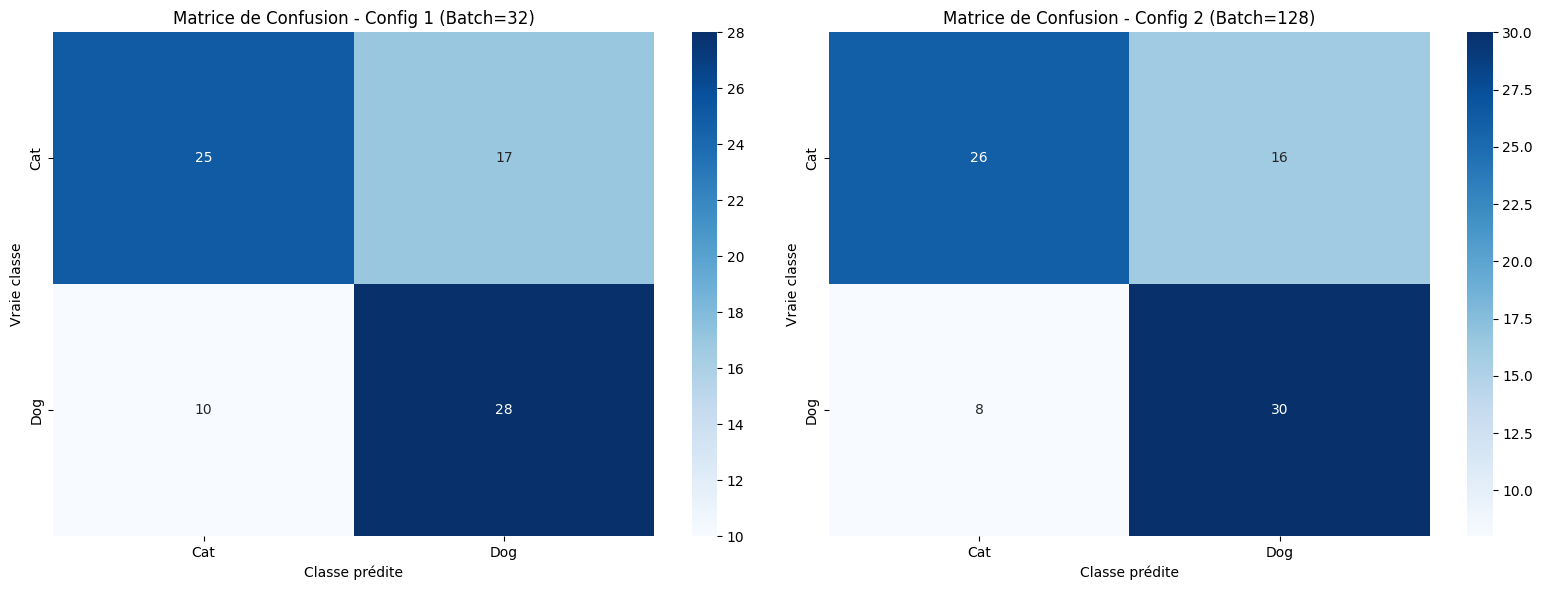


=== RAPPORT Config 1 ===
              precision    recall  f1-score   support

         Cat       0.71      0.60      0.65        42
         Dog       0.62      0.74      0.67        38

    accuracy                           0.66        80
   macro avg       0.67      0.67      0.66        80
weighted avg       0.67      0.66      0.66        80


=== RAPPORT Config 2 ===
              precision    recall  f1-score   support

         Cat       0.76      0.62      0.68        42
         Dog       0.65      0.79      0.71        38

    accuracy                           0.70        80
   macro avg       0.71      0.70      0.70        80
weighted avg       0.71      0.70      0.70        80



In [13]:
# Matrice de confusion pour Config 1
y_true_q2_c1 = []
y_pred_q2_c1 = []

for images, labels in test_datagen_32:
    predictions = model_q2_config1.predict(images, verbose=0)
    y_true_q2_c1.extend(labels.numpy())
    y_pred_q2_c1.extend(np.argmax(predictions, axis=1))

cm_q2_c1 = confusion_matrix(y_true_q2_c1, y_pred_q2_c1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_q2_c1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Matrice de Confusion - Config 1 (Batch=32)')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe prédite')

# Matrice de confusion pour Config 2
y_true_q2_c2 = []
y_pred_q2_c2 = []

for images, labels in test_datagen_128:
    predictions = model_q2_config2.predict(images, verbose=0)
    y_true_q2_c2.extend(labels.numpy())
    y_pred_q2_c2.extend(np.argmax(predictions, axis=1))

cm_q2_c2 = confusion_matrix(y_true_q2_c2, y_pred_q2_c2)

sns.heatmap(cm_q2_c2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Matrice de Confusion - Config 2 (Batch=128)')
axes[1].set_ylabel('Vraie classe')
axes[1].set_xlabel('Classe prédite')

plt.tight_layout()
plt.show()

print("\n=== RAPPORT Config 1 ===")
print(classification_report(y_true_q2_c1, y_pred_q2_c1, target_names=class_names))
print("\n=== RAPPORT Config 2 ===")
print(classification_report(y_true_q2_c2, y_pred_q2_c2, target_names=class_names))

## Question 3 : Introduction du Dropout (20%)

In [14]:
# Modèle avec Dropout 20%
model_q3 = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout 20%
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  # Dropout 20%
    
    layers.Dense(len(class_names), activation='softmax')
])

model_q3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== Modèle avec Dropout 20% ===")
model_q3.summary()

=== Modèle avec Dropout 20% ===


c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 156816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │     5,018,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,018,370 (19.14 MB)

 Trainable params: 5,018,370 (19.14 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entraînement du modèle Q3
history_q3 = model_q3.fit(
    train_datagen,
    epochs=Nb_epochs,
    validation_data=test_datagen
)

test_loss_q3, test_accuracy_q3 = model_q3.evaluate(test_datagen)
print(f'\nModèle Q3 (avec Dropout) - Test Accuracy: {test_accuracy_q3:.4f}')

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4882 - loss: 2.0887 - val_accuracy: 0.5167 - val_loss: 1.1517
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4882 - loss: 2.0887 - val_accuracy: 0.5167 - val_loss: 1.1517
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4956 - loss: 0.8216 - val_accuracy: 0.4833 - val_loss: 0.7002
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4956 - loss: 0.8216 - val_accuracy: 0.4833 - val_loss: 0.7002
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5456 - loss: 0.6932 - val_accuracy: 0.5917 - val_loss: 0.6869
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5456 - loss: 0.6932 - val_accuracy: 0.5917 - val_loss: 0.6869
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.6397 - loss: 0.6741 - val_accuracy: 0.6000 - val_loss: 0.6792
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.6397 - loss: 0.6741 - val_accuracy: 0.

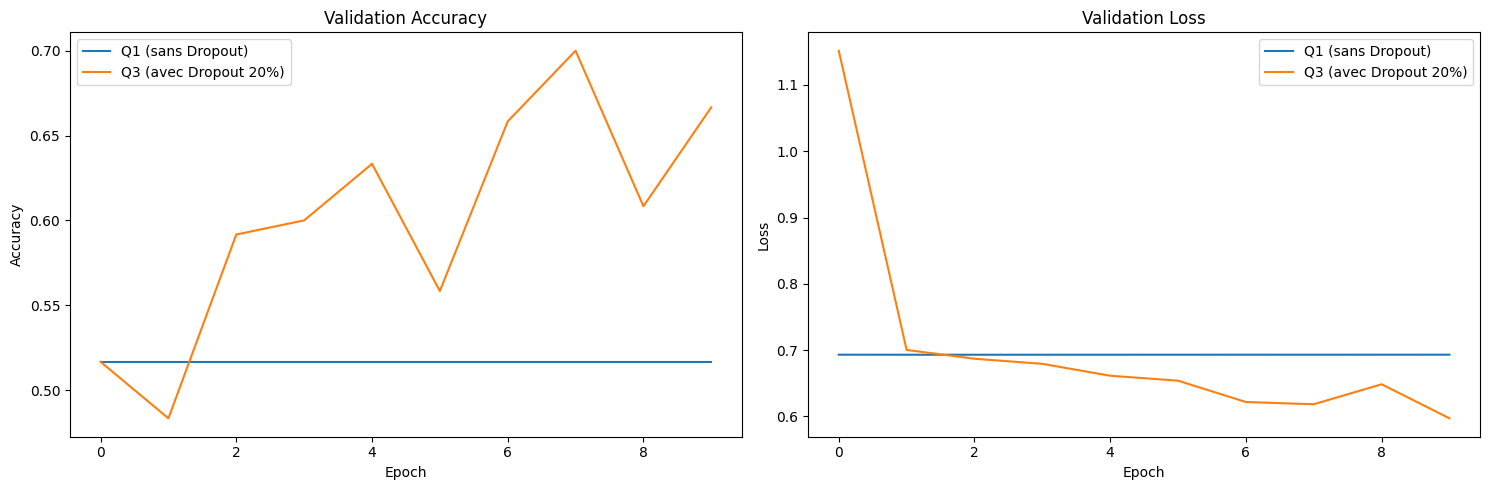


Q1 (sans Dropout) - Test Accuracy: 0.5167
Q3 (avec Dropout) - Test Accuracy: 0.6667


In [16]:
# Comparaison Q1 vs Q3
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_q1.history['val_accuracy'], label='Q1 (sans Dropout)')
axes[0].plot(history_q3.history['val_accuracy'], label='Q3 (avec Dropout 20%)')
axes[0].set_title('Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss
axes[1].plot(history_q1.history['val_loss'], label='Q1 (sans Dropout)')
axes[1].plot(history_q3.history['val_loss'], label='Q3 (avec Dropout 20%)')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nQ1 (sans Dropout) - Test Accuracy: {test_accuracy_q1:.4f}")
print(f"Q3 (avec Dropout) - Test Accuracy: {test_accuracy_q3:.4f}")

### Matrice de confusion - Modèle Q3

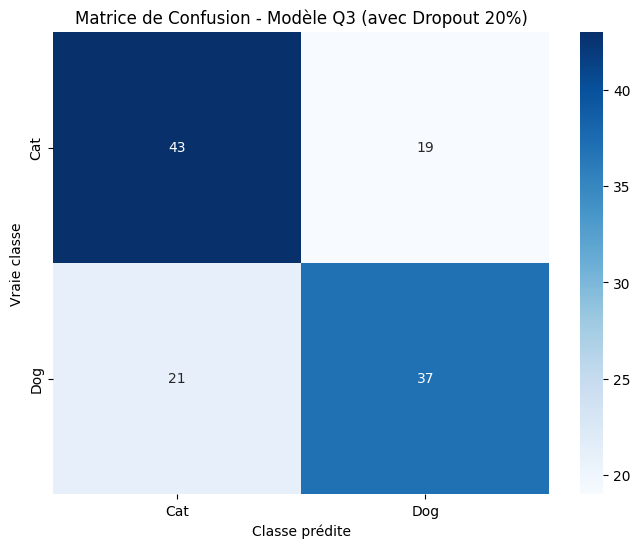


=== RAPPORT DE CLASSIFICATION Q3 ===
              precision    recall  f1-score   support

         Cat       0.67      0.69      0.68        62
         Dog       0.66      0.64      0.65        58

    accuracy                           0.67       120
   macro avg       0.67      0.67      0.67       120
weighted avg       0.67      0.67      0.67       120



In [17]:
# Matrice de confusion pour Q3
y_true_q3 = []
y_pred_q3 = []

for images, labels in test_datagen:
    predictions = model_q3.predict(images, verbose=0)
    y_true_q3.extend(labels.numpy())
    y_pred_q3.extend(np.argmax(predictions, axis=1))

cm_q3 = confusion_matrix(y_true_q3, y_pred_q3)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_q3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Q3 (avec Dropout 20%)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

print("\n=== RAPPORT DE CLASSIFICATION Q3 ===")
print(classification_report(y_true_q3, y_pred_q3, target_names=class_names))

## Question 4 : Modèle profond avec architecture spécifique

Architecture imposée :
- 1 couche convolutionnelle de 32 filtres 3x3 (avec MaxPooling et ReLU)
- 3 couches convolutionnelles de 64 filtres 3x3 (avec MaxPooling et ReLU)
- 3 couches denses de 512 neurones (avec BatchNormalization et Dropout)
- 1 couche de sortie

In [18]:
# Modèle profond selon les spécifications EXACTES Q4

model_q4 = tf.keras.Sequential([
    # 1 couche convolutionnelle de 32 filtres de taille 3x3
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # 3 couches convolutionnelles de 64 filtres de taille 3x3
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    # 3 couches denses de 512 neurones avec BatchNormalization et Dropout
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Couche de sortie avec softmax
    layers.Dense(len(class_names), activation='softmax')
])

# Compilation avec un learning rate adapté
from tensorflow.keras.optimizers import Adam

model_q4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== Modèle Profond Q4 ===")
model_q4.summary()

=== Modèle Profond Q4 ===


c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,902,466 (14.89 MB)

 Trainable params: 3,899,394 (14.88 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [19]:
# Entraînement du modèle Q4 avec callbacks pour éviter le surapprentissage
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping pour arrêter si le modèle ne s'améliore plus
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Réduction du learning rate si le modèle stagne
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

print("=== Entraînement du Modèle Q4 ===")
history_q4 = model_q4.fit(
    train_datagen,
    epochs=30,  # Plus d'epochs mais avec early stopping
    validation_data=test_datagen,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_loss_q4, test_accuracy_q4 = model_q4.evaluate(test_datagen)
print(f'\nModèle Q4 (Profond) - Test Accuracy: {test_accuracy_q4:.4f}')

=== Entraînement du Modèle Q4 ===
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 851ms/step - accuracy: 0.5088 - loss: 1.2063 - val_accuracy: 0.4833 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 851ms/step - accuracy: 0.5088 - loss: 1.2063 - val_accuracy: 0.4833 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 867ms/step - accuracy: 0.5382 - loss: 1.1242 - val_accuracy: 0.4833 - val_loss: 0.6959 - learning_rate: 1.0000e-04
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 867ms/step - accuracy: 0.5382 - loss: 1.1242 - val_accuracy: 0.4833 - val_loss: 0.6959 - learning_rate: 1.0000e-04
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 830ms/step - accuracy: 0.5779 - loss: 1.1170 - val_accuracy: 0.4833 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 830ms/step - accuracy: 0.5779 - loss: 1.1170 - val_accuracy: 0.4833 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 4/30
11/11 ━━━━━━━━━

### Diagnostic du Modèle Q4

=== DIAGNOSTIC MODÈLE Q4 ===

Distribution des prédictions :
  Dog: 120 prédictions (100.0%)

Distribution réelle :
  Cat: 62 images (51.7%)
  Dog: 58 images (48.3%)

Confiance moyenne des prédictions :
  Chat (classe 0): 0.4816
  Chien (classe 1): 0.5184
Distribution des prédictions :
  Dog: 120 prédictions (100.0%)

Distribution réelle :
  Cat: 62 images (51.7%)
  Dog: 58 images (48.3%)

Confiance moyenne des prédictions :
  Chat (classe 0): 0.4816
  Chien (classe 1): 0.5184


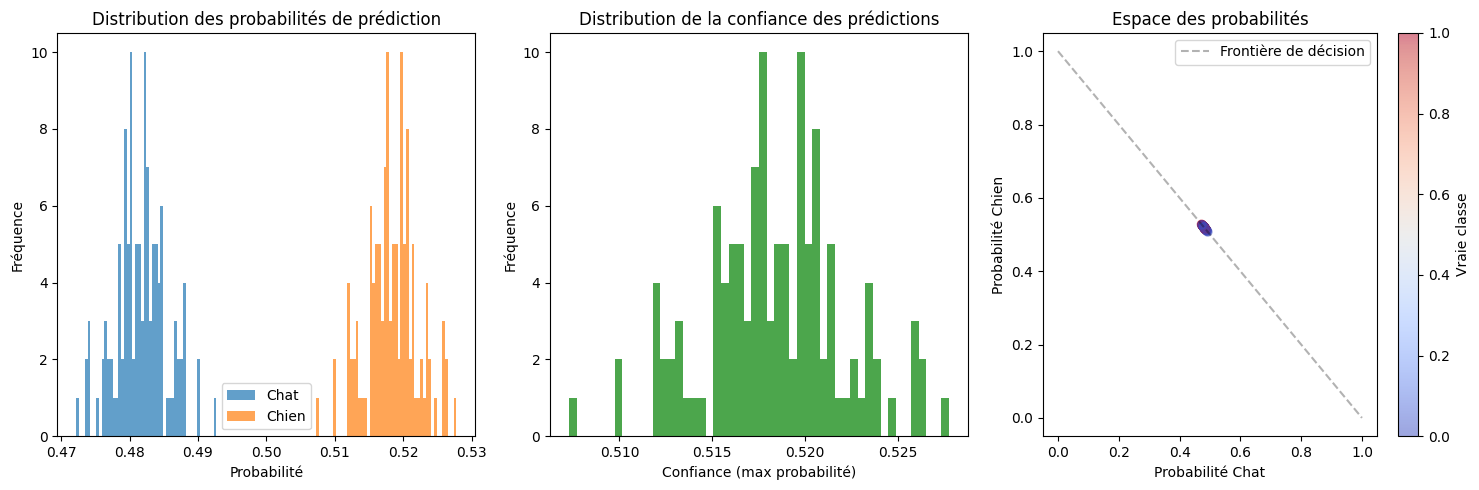

In [20]:
# Analyse détaillée du modèle Q4
print("=== DIAGNOSTIC MODÈLE Q4 ===\n")

# Vérification de la distribution des prédictions
y_true_q4 = []
y_pred_q4 = []
y_pred_proba_q4 = []

for images, labels in test_datagen:
    predictions = model_q4.predict(images, verbose=0)
    y_true_q4.extend(labels.numpy())
    y_pred_q4.extend(np.argmax(predictions, axis=1))
    y_pred_proba_q4.extend(predictions)

y_pred_proba_q4 = np.array(y_pred_proba_q4)

# Distribution des prédictions
unique, counts = np.unique(y_pred_q4, return_counts=True)
print("Distribution des prédictions :")
for cls, count in zip(unique, counts):
    print(f"  {class_names[cls]}: {count} prédictions ({count/len(y_pred_q4)*100:.1f}%)")

print(f"\nDistribution réelle :")
unique_true, counts_true = np.unique(y_true_q4, return_counts=True)
for cls, count in zip(unique_true, counts_true):
    print(f"  {class_names[cls]}: {count} images ({count/len(y_true_q4)*100:.1f}%)")

# Analyse des probabilités de prédiction
print(f"\nConfiance moyenne des prédictions :")
print(f"  Chat (classe 0): {y_pred_proba_q4[:, 0].mean():.4f}")
print(f"  Chien (classe 1): {y_pred_proba_q4[:, 1].mean():.4f}")

# Distribution des probabilités
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y_pred_proba_q4[:, 0], bins=50, alpha=0.7, label='Chat')
plt.hist(y_pred_proba_q4[:, 1], bins=50, alpha=0.7, label='Chien')
plt.xlabel('Probabilité')
plt.ylabel('Fréquence')
plt.title('Distribution des probabilités de prédiction')
plt.legend()

plt.subplot(1, 3, 2)
confidence = np.max(y_pred_proba_q4, axis=1)
plt.hist(confidence, bins=50, color='green', alpha=0.7)
plt.xlabel('Confiance (max probabilité)')
plt.ylabel('Fréquence')
plt.title('Distribution de la confiance des prédictions')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_proba_q4[:, 0], y_pred_proba_q4[:, 1], alpha=0.5, c=y_true_q4, cmap='coolwarm')
plt.xlabel('Probabilité Chat')
plt.ylabel('Probabilité Chien')
plt.title('Espace des probabilités')
plt.colorbar(label='Vraie classe')
plt.plot([0, 1], [1, 0], 'k--', alpha=0.3, label='Frontière de décision')
plt.legend()

plt.tight_layout()
plt.show()

### Matrice de confusion - Modèle Q4

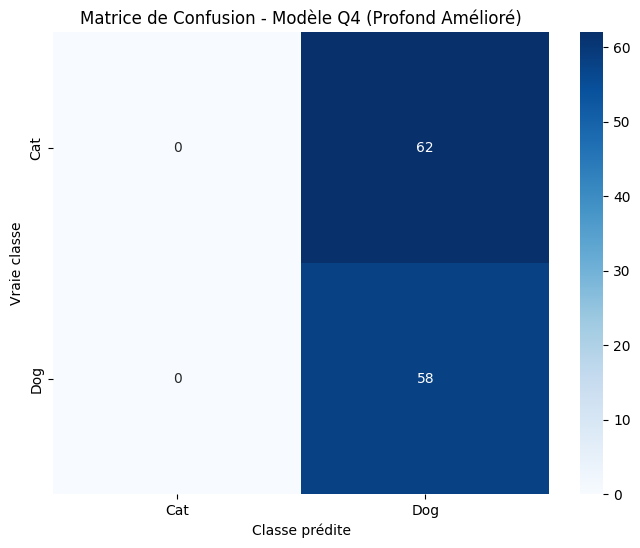


=== RAPPORT DE CLASSIFICATION Q4 ===
              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00        62
         Dog       0.48      1.00      0.65        58

    accuracy                           0.48       120
   macro avg       0.24      0.50      0.33       120
weighted avg       0.23      0.48      0.31       120



c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [21]:
# Matrice de confusion pour Q4
cm_q4 = confusion_matrix(y_true_q4, y_pred_q4)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_q4, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Q4 (Profond Amélioré)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

print("\n=== RAPPORT DE CLASSIFICATION Q4 ===")
print(classification_report(y_true_q4, y_pred_q4, target_names=class_names))


COMPARAISON FINALE DES MODÈLES
Q1 - Modèle minimaliste         : 0.5167
Q3 - Modèle avec Dropout 20%    : 0.6667
Q4 - Modèle profond              : 0.4833


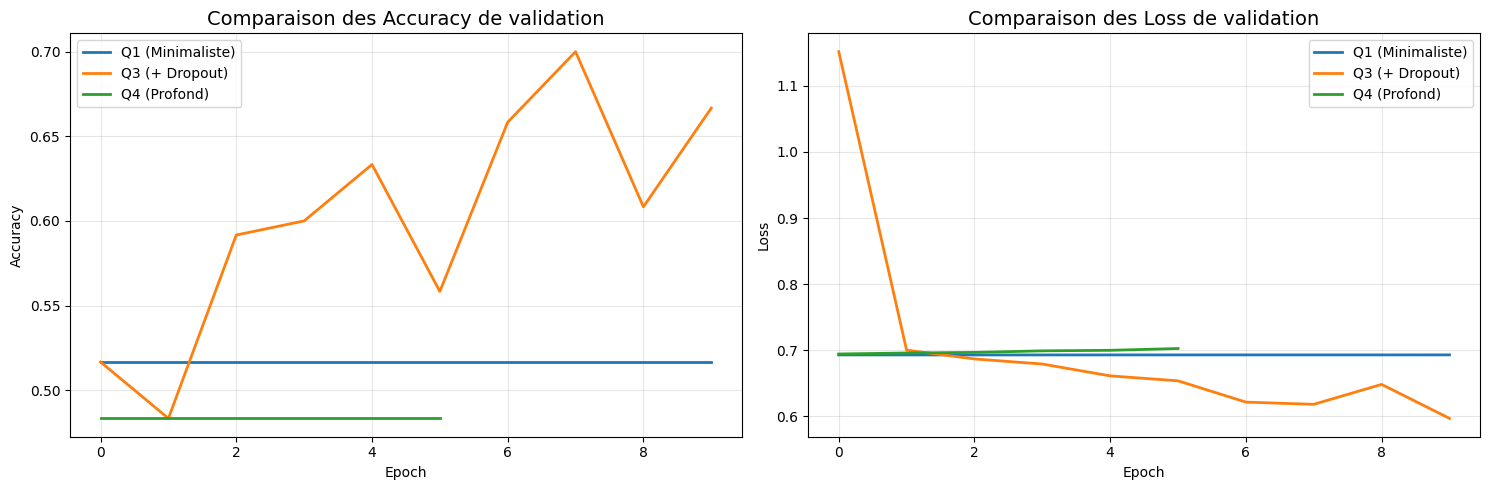

In [22]:
# Comparaison finale de tous les modèles
print("\n" + "="*60)
print("COMPARAISON FINALE DES MODÈLES")
print("="*60)
print(f"Q1 - Modèle minimaliste         : {test_accuracy_q1:.4f}")
print(f"Q3 - Modèle avec Dropout 20%    : {test_accuracy_q3:.4f}")
print(f"Q4 - Modèle profond              : {test_accuracy_q4:.4f}")
print("="*60)

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validation Accuracy
axes[0].plot(history_q1.history['val_accuracy'], label='Q1 (Minimaliste)', linewidth=2)
axes[0].plot(history_q3.history['val_accuracy'], label='Q3 (+ Dropout)', linewidth=2)
axes[0].plot(history_q4.history['val_accuracy'], label='Q4 (Profond)', linewidth=2)
axes[0].set_title('Comparaison des Accuracy de validation', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Loss
axes[1].plot(history_q1.history['val_loss'], label='Q1 (Minimaliste)', linewidth=2)
axes[1].plot(history_q3.history['val_loss'], label='Q3 (+ Dropout)', linewidth=2)
axes[1].plot(history_q4.history['val_loss'], label='Q4 (Profond)', linewidth=2)
axes[1].set_title('Comparaison des Loss de validation', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparaison des Matrices de Confusion

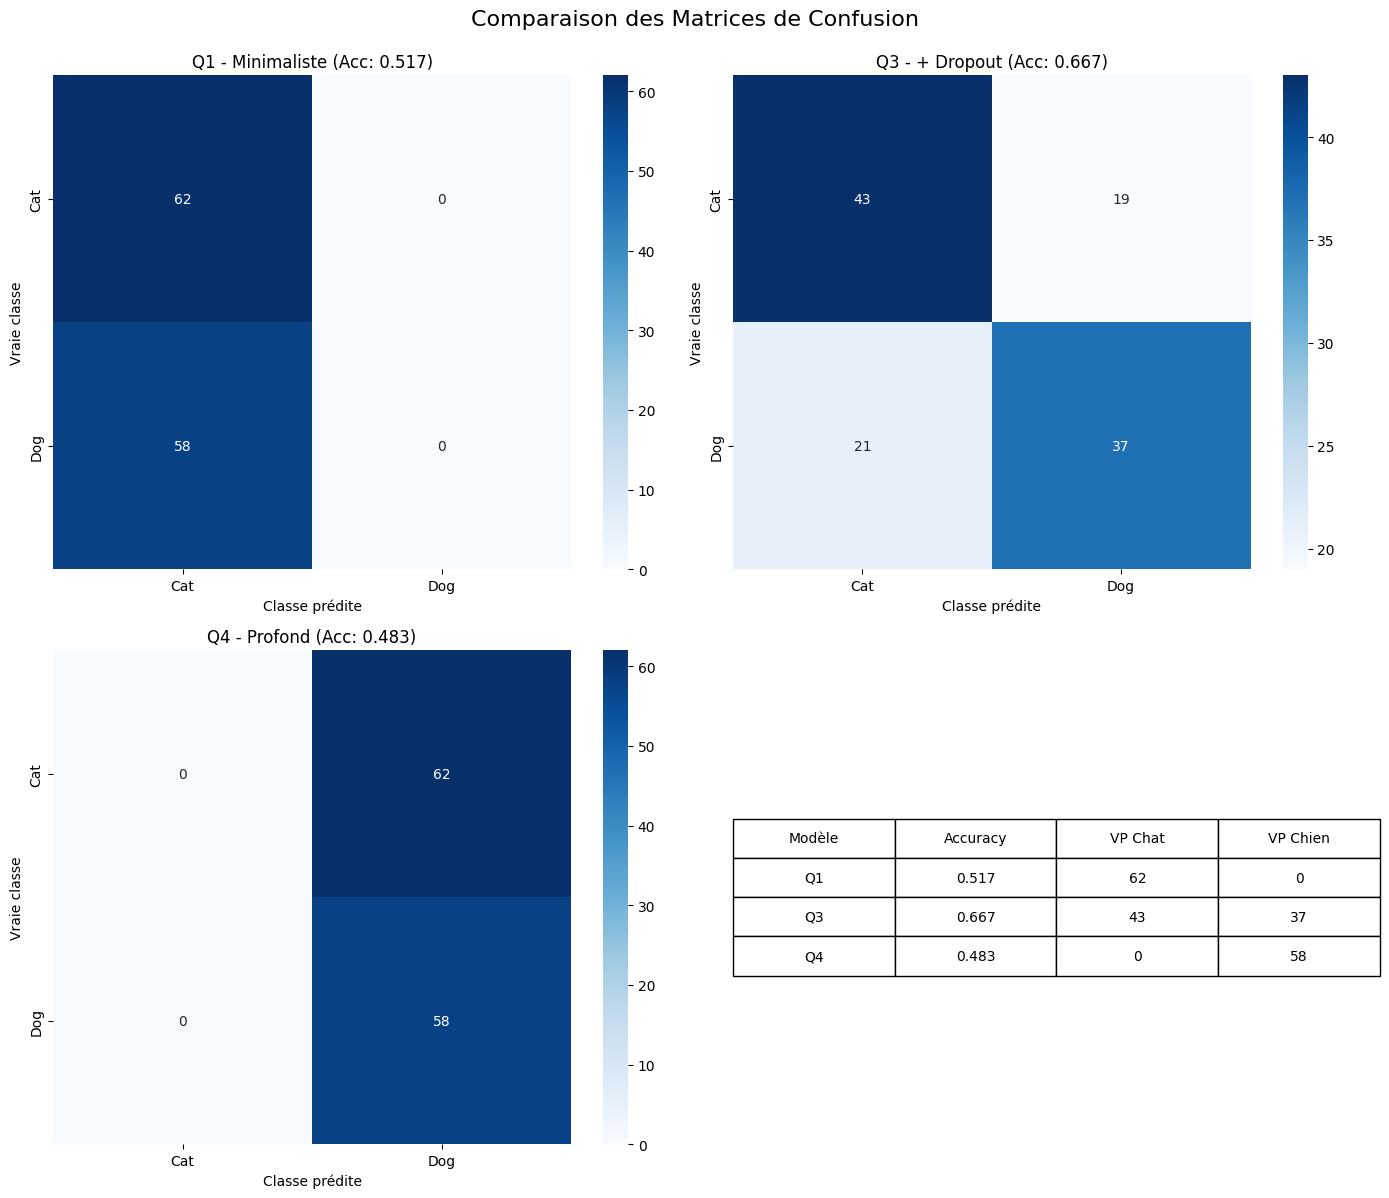

In [23]:
# Affichage côte à côte des matrices de confusion
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Q1
sns.heatmap(cm_q1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title(f'Q1 - Minimaliste (Acc: {test_accuracy_q1:.3f})')
axes[0, 0].set_ylabel('Vraie classe')
axes[0, 0].set_xlabel('Classe prédite')

# Q3
sns.heatmap(cm_q3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 1])
axes[0, 1].set_title(f'Q3 - + Dropout (Acc: {test_accuracy_q3:.3f})')
axes[0, 1].set_ylabel('Vraie classe')
axes[0, 1].set_xlabel('Classe prédite')

# Q4
sns.heatmap(cm_q4, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[1, 0])
axes[1, 0].set_title(f'Q4 - Profond (Acc: {test_accuracy_q4:.3f})')
axes[1, 0].set_ylabel('Vraie classe')
axes[1, 0].set_xlabel('Classe prédite')

# Comparaison des métriques
metrics_comparison = {
    'Modèle': ['Q1', 'Q3', 'Q4'],
    'Accuracy': [test_accuracy_q1, test_accuracy_q3, test_accuracy_q4],
    'Vrais Positifs (Chat)': [cm_q1[0, 0], cm_q3[0, 0], cm_q4[0, 0]],
    'Vrais Positifs (Chien)': [cm_q1[1, 1], cm_q3[1, 1], cm_q4[1, 1]]
}

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = [[m, f"{a:.3f}", vp_c, vp_d] 
              for m, a, vp_c, vp_d in zip(
                  metrics_comparison['Modèle'],
                  metrics_comparison['Accuracy'],
                  metrics_comparison['Vrais Positifs (Chat)'],
                  metrics_comparison['Vrais Positifs (Chien)']
              )]
table = axes[1, 1].table(cellText=table_data, 
                         colLabels=['Modèle', 'Accuracy', 'VP Chat', 'VP Chien'],
                         cellLoc='center',
                         loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.suptitle('Comparaison des Matrices de Confusion', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Sauvegarde du meilleur modèle

In [24]:
# Sauvegarde du modèle Q4 (meilleur modèle)
model_q4.save('modele_q4_profond.h5')
print("Modèle Q4 sauvegardé avec succès dans 'modele_q4_profond.h5' !")

# Pour charger le modèle plus tard :
# model_loaded = tf.keras.models.load_model('modele_q4_profond.h5')

Modèle Q4 sauvegardé avec succès dans 'modele_q4_profond.h5' !
